In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pickle
import joblib

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import os

In [33]:
pd.options.display.float_format = '{:20,.2f}'.format

In [34]:
steam_data2 = pd.read_csv('../data/steam_clean2.csv', parse_dates=['release_date'], index_col=0)

In [35]:
steam_data2.shape

(26356, 43)

In [36]:
steam_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26356 entries, 0 to 27074
Data columns (total 43 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   appid             26356 non-null  int64         
 1   name              26356 non-null  object        
 2   release_date      26356 non-null  datetime64[ns]
 3   yrs_released      26356 non-null  int64         
 4   winter            26356 non-null  int64         
 5   spring            26356 non-null  int64         
 6   summer            26356 non-null  int64         
 7   fall              26356 non-null  int64         
 8   achievements      26356 non-null  int64         
 9   average_playtime  26356 non-null  int64         
 10  median_playtime   26356 non-null  int64         
 11  price             26356 non-null  float64       
 12  avg_owners        26356 non-null  float64       
 13  revenue           26356 non-null  float64       
 14  total_ratings     2635

# I. Predicting Revenue

### Preprocessing

#### a. Split into Train/Test

In [263]:
# Remove free games from the dataset
paid_games = steam_data2.loc[steam_data2['free_to_play']==0]
free_games = steam_data2.loc[steam_data2['free_to_play']==1]

# Define X and y
cols_to_drop = ['price', 'avg_owners', 'revenue', 'appid', 'name', 'release_date', 'free_to_play']
X = paid_games.drop(columns=cols_to_drop)
y = paid_games.revenue

In [112]:
X.shape, y.shape

((24515, 36), (24515,))

In [264]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [114]:
X_train.shape, X_test.shape

((17160, 36), (7355, 36))

#### b. Scale Data

In [265]:
# Initialize scaler
scaler = StandardScaler()

# Fit to training data
scaler.fit(X_train)
# Transform train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
# Function to quickly assess different models

def print_eval(model, X_tr, X_te, y_tr, y_te):
    """Quickly evaluate different models"""
    model.fit(X_tr, y_tr)
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)
    r2_tr, r2_te = r2_score(y_tr, y_tr_pred), r2_score(y_te, y_te_pred)
    rmse_tr, rmse_te = np.sqrt(mean_squared_error(y_tr, y_tr_pred)), np.sqrt(mean_squared_error(y_te, y_te_pred))
    mae_tr, mae_te = mean_absolute_error(y_tr, y_tr_pred), mean_absolute_error(y_te, y_te_pred)
    print(f"Train R2: {r2_tr:.2f}  |  Test R2: {r2_te:.2f} \n"
         f"Train RMSE: {rmse_tr:,.2f}  |  Test RMSE: {rmse_te:,.2f} \n"
         f"Train MAE: {mae_tr:,.2f}  |  Test MAE: {mae_te:,.2f}")

## Model 1: Linear Regression

In [43]:
from sklearn.linear_model import LinearRegression

### a. Baseline Model

In [266]:
# Initialize model
lm = LinearRegression()

# Fit, predict, and evaluate
print_eval(lm, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.72  |  Test R2: 0.16 
Train RMSE: 9,448,986.42  |  Test RMSE: 6,725,399.03 
Train MAE: 1,228,114.78  |  Test MAE: 1,167,911.55


As expected, the baseline LR model doesn't perform well. We'll see if adjusting k and type of scaler affects performance in any way.

### b. Cross-Validation

In [161]:
# Set parameters
k_range = [k+1 for k in range(9, len(X_train.columns))]

param_grid_LR = {'standardscaler': [StandardScaler(), RobustScaler(), MaxAbsScaler(), None], 'selectkbest__k': k_range}

# Create Pipeline
pipe_LR = make_pipeline(StandardScaler(), SelectKBest(f_regression), lm)
pipe_LR.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'linearregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [252]:
# Grid Search CV

gridcv_LR = GridSearchCV(pipe_LR, param_grid=param_grid_LR, cv=5, 
                         scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'],
                         refit='r2', n_jobs=-1)
gridcv_LR.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000002534EDDC0D0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [10, 11, 12, 13, 14, 15, 16, 17, 18,
                                            19, 20, 21, 22, 23, 24, 25, 26, 27,
                                            28, 29, 30, 31, 32, 33, 34, 35,
                                            36],
                         'standardscaler': [StandardScaler(), RobustScaler(),
                                            MaxAbsScaler(), None]},
             refit='r2',
             scoring=['r2', 'neg_root_mean_squared_error',
                      'neg_mean_absolute_error'])

In [253]:
gridcv_LR.best_estimator_, gridcv_LR.best_params_, gridcv_LR.best_score_

(Pipeline(steps=[('standardscaler', None),
                 ('selectkbest',
                  SelectKBest(k=13,
                              score_func=<function f_regression at 0x000002534EDDC0D0>)),
                 ('linearregression', LinearRegression())]),
 {'selectkbest__k': 13, 'standardscaler': None},
 0.04610440183165974)

In [254]:
# Using the best model 

print_eval(gridcv_LR.best_estimator_, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.74  |  Test R2: 0.13 
Train RMSE: 8,813,540.38  |  Test RMSE: 8,818,735.64 
Train MAE: 1,127,178.33  |  Test MAE: 1,152,810.45


Based on Grid Search CV, the best model has k = 16. Performance is still not that great, and doesn't even out-perform the baseline LR model.

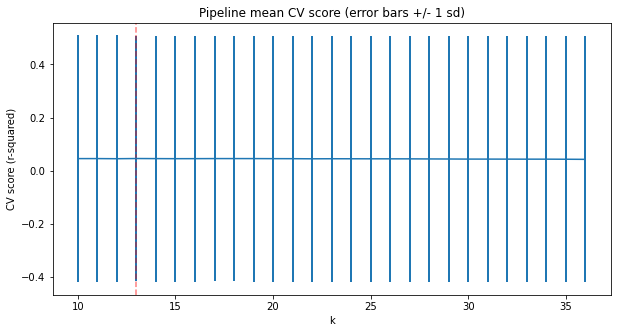

In [255]:
# Plotting performance at different levels of k

score_mean = gridcv_LR.cv_results_['mean_test_r2']
score_std = gridcv_LR.cv_results_['std_test_r2']
cv_k = [k for k in gridcv_LR.cv_results_['param_selectkbest__k']]

best_k = gridcv_LR.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1 sd)');

Adjusting the value of k doesn't seem to affect model performance very much

## Model 1.5: Linear Regression with Regularization

#### a. Lasso Regression

In [124]:
from sklearn.linear_model import Lasso

In [267]:
# Initialize Model
lasso = Lasso(random_state=1)

# Fit and evaluate
print_eval(lasso, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.72  |  Test R2: 0.16 
Train RMSE: 9,448,986.04  |  Test RMSE: 6,725,389.15 
Train MAE: 1,228,062.52  |  Test MAE: 1,167,860.84


#### b. Ridge Regression

In [52]:
from sklearn.linear_model import Ridge

In [268]:
# Initialize Model
ridge = Ridge(random_state=1)

# Fit and evaluate
print_eval(ridge, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.72  |  Test R2: 0.17 
Train RMSE: 9,448,986.09  |  Test RMSE: 6,725,100.50 
Train MAE: 1,228,017.17  |  Test MAE: 1,167,818.46


Neither of these regularization techniques show a significant improvement to our baseline LR model, or the LR model with optimized k. The next model to test will be the random forest regressor.

## Model 2: Random Forest Regressor

In [54]:
from sklearn.ensemble import RandomForestRegressor

### a. Baseline Model

In [269]:
# Initialize model
RFreg = RandomForestRegressor(random_state=1)

# Fit and evaluate model
print_eval(RFreg, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.93  |  Test R2: 0.66 
Train RMSE: 4,635,625.32  |  Test RMSE: 4,273,436.80 
Train MAE: 290,693.07  |  Test MAE: 701,797.38


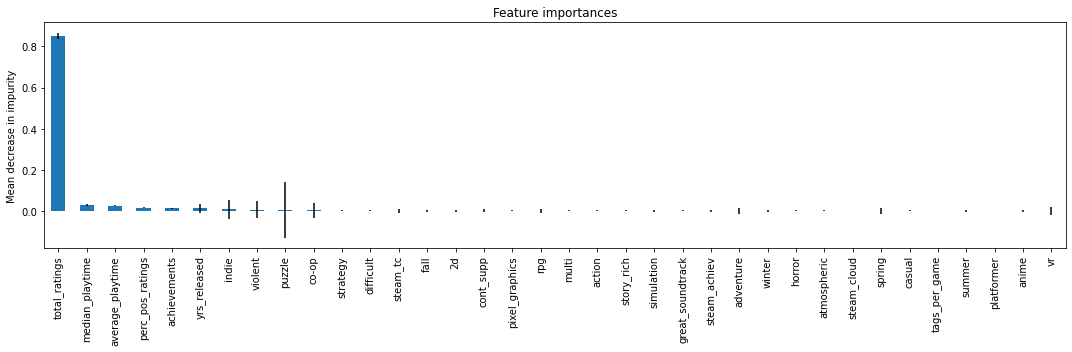

In [270]:
# Viewing feature importances

importances = RFreg.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFreg.estimators_], axis=0)

# Plot
forest_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

The baseline random forest model shows a noticeable improvement to all the linear regression models in regard to all 3 metrics. Now, I'll test out different hyperparameters to see if the RF model can be improved further.

### b. Tuning Hyperparameters

In [128]:
# Create Pipeline
pipe_RF = make_pipeline(StandardScaler(), SelectKBest(f_regression), RFreg)
pipe_RF.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'randomforestregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [151]:
# Set hyperparameters to search over

n_est = [int(x) for x in np.linspace(start=100,stop=1000,num=10)]
max_depth = [int(x) for x in np.linspace(start=10,stop=100,num=10)]
k_range = [k+1 for k in range(9,len(X_train.columns))]

param_grid_RF = [
    {'standardscaler': [StandardScaler(), RobustScaler(), MaxAbsScaler(), None], 'selectkbest__k': k_range, 
     'randomforestregressor__n_estimators':n_est, 'randomforestregressor__max_depth':max_depth}]

In [152]:
# Randomized Search CV

randomcv_rf = RandomizedSearchCV(pipe_RF, param_distributions=param_grid_RF, cv=5,
                                 scoring=['r2','neg_root_mean_squared_error','neg_mean_absolute_error'],
                                 refit='r2', n_iter=75, n_jobs=-1)

randomcv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('selectkbest',
                                              SelectKBest(score_func=<function f_regression at 0x000002534EDDC0D0>)),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=1))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions=[{'randomforestregressor__max_depth': [10,
                                                                              20,
                                                                              30,
                                                                              40,
                                                                              50,
                                                         

In [153]:
# Best estimator properties

randomcv_rf.best_estimator_, randomcv_rf.best_params_, randomcv_rf.best_score_

(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('selectkbest',
                  SelectKBest(k=17,
                              score_func=<function f_regression at 0x000002534EDDC0D0>)),
                 ('randomforestregressor',
                  RandomForestRegressor(max_depth=100, n_estimators=700,
                                        random_state=1))]),
 {'standardscaler': StandardScaler(),
  'selectkbest__k': 17,
  'randomforestregressor__n_estimators': 700,
  'randomforestregressor__max_depth': 100},
 0.5443461074055357)

It seems the best RF model has a depth of 100 and 700 estimators. The best value of k here is 17.

In [154]:
print_eval(randomcv_rf.best_estimator_, X_train, X_test, y_train, y_test)

Train R2: 0.91  |  Test R2: 0.60 
Train RMSE: 5,167,456.84  |  Test RMSE: 5,026,463.55 
Train MAE: 297,120.28  |  Test MAE: 679,147.73


The best model based on randomized search CV performs similarly to the baseline RF model. Let's explore this further

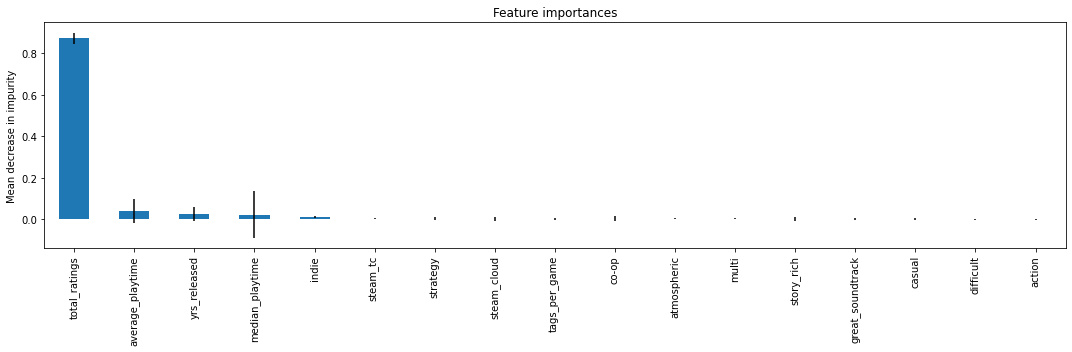

In [155]:
# Viewing feature importances

RFbest = randomcv_rf.best_estimator_.named_steps.randomforestregressor
importances = RFbest.feature_importances_
cols = randomcv_rf.best_estimator_.named_steps.selectkbest.get_support(indices=True)
feature_cols = X_train.iloc[:,cols]

std = np.std([tree.feature_importances_ for tree in RFbest.estimators_], axis=0)

# Plot
forest_importances = pd.Series(importances, index=feature_cols.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

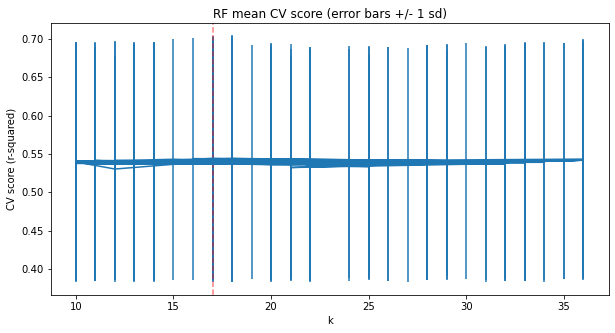

In [156]:
# Plotting performance at different levels of k

score_mean = randomcv_rf.cv_results_['mean_test_r2']
score_std = randomcv_rf.cv_results_['std_test_r2']
cv_k = [k for k in randomcv_rf.cv_results_['param_selectkbest__k']]

best_k = randomcv_rf.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('RF mean CV score (error bars +/- 1 sd)');

## Model 3: Gradient Boosting Regression

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

### a. Baseline Model

In [271]:
# Initialize model
GBreg = GradientBoostingRegressor(random_state=1)

# Fit, predict, and evaluate
print_eval(GBreg, X_train_scaled, X_test_scaled, y_train, y_test)

Train R2: 0.98  |  Test R2: 0.68 
Train RMSE: 2,516,170.84  |  Test RMSE: 4,165,984.56 
Train MAE: 500,681.21  |  Test MAE: 676,584.12


The baseline GB model seems to perform somewhere between the RF and LR models. Again, I'll test out different hyperparameters to identify an optimal GB model.

### b. Tuning Hyperparameters

In [138]:
# Create Pipeline
pipe_GB = make_pipeline(StandardScaler(), SelectKBest(f_regression), GBreg)
pipe_GB.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'selectkbest', 'gradientboostingregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estimators', 'gradientboostingregressor__n_iter_no_change', 'gradientboostingregressor__random_state', 'gradientboostingregressor__s

In [139]:
# Define hyperparameters to search over

n_est = [int(x) for x in np.linspace(start=100,stop=1000,num=10)]
max_feat = ['auto','sqrt','log2',None]
max_depth = [int(x) for x in np.linspace(start=10,stop=100,num=10)]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4]
k_range = [k+1 for k in range(9,len(X_train.columns))]

param_grid_GB = [
    {'standardscaler': [StandardScaler(), RobustScaler(), MaxAbsScaler(), None], 'selectkbest__k': k_range, 
     'gradientboostingregressor__n_estimators':n_est, 'gradientboostingregressor__max_depth':max_depth,
     'gradientboostingregressor__max_features':max_feat, 'gradientboostingregressor__learning_rate':learning_rate}]

In [157]:
# Randomized Search CV

randomcv_gb = RandomizedSearchCV(pipe_GB, param_distributions=param_grid_GB, cv=5, 
                                 scoring=['r2','neg_root_mean_squared_error'],
                                 refit='r2', n_iter=75, n_jobs=-1)
randomcv_gb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('selectkbest',
                                              SelectKBest(score_func=<function f_regression at 0x000002534EDDC0D0>)),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=1))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions=[{'gradientboostingregressor__learning_rate': [0.001,
                                                                                      0.01,
                                                                                      0.1,
                                                                                      0.2,
                                                                                      0....


In [166]:
# Best estimator properties

randomcv_gb.best_estimator_, randomcv_gb.best_params_, randomcv_gb.best_score_

(Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('selectkbest',
                  SelectKBest(k=11,
                              score_func=<function f_regression at 0x000002534EDDC0D0>)),
                 ('gradientboostingregressor',
                  GradientBoostingRegressor(learning_rate=0.4, max_depth=70,
                                            max_features='log2',
                                            n_estimators=300, random_state=1))]),
 {'standardscaler': StandardScaler(),
  'selectkbest__k': 11,
  'gradientboostingregressor__n_estimators': 300,
  'gradientboostingregressor__max_features': 'log2',
  'gradientboostingregressor__max_depth': 70,
  'gradientboostingregressor__learning_rate': 0.4},
 0.5148628344219983)

The best GB model has 300 estimators, a max depth of 80, and a learning rate of 0.001

In [167]:
print_eval(randomcv_gb.best_estimator_, X_train, X_test, y_train, y_test)

Train R2: 1.00  |  Test R2: 0.31 
Train RMSE: 26,066.59  |  Test RMSE: 6,572,124.57 
Train MAE: 8,227.34  |  Test MAE: 826,511.45


Strangely, hyperparameter tuning has resulted in a weaker model.

# III. Compare All Models

In [272]:
models = [('lin_reg', lm), ('lin_reg_bestk', gridcv_LR.best_estimator_), 
          ('RandomForest', RFreg), ('RandomForest_RandomCV', randomcv_rf.best_estimator_),
          ('GradientBoost', GBreg), ('GradientBoost_RandomCV', randomcv_gb.best_estimator_)]
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']

results= {}
for name, model in models:
    results[name] = {}
    for i in scoring:        
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=5, return_train_score=True)
        results[name][i] = scores

In [273]:
R2_mean_train = []
R2_std_train = []
R2_mean_test = []
R2_std_test = []
RMSE_mean_train = []
RMSE_std_train = []
RMSE_mean_test = []
RMSE_std_test = []
MAE_mean_train = []
MAE_std_train = []
MAE_mean_test = []
MAE_std_test = []

for model in results:
    # Append R2
    R2_mean_train.append(results[model]['r2']['train_score'].mean())
    R2_std_train.append(results[model]['r2']['train_score'].std())
    R2_mean_test.append(results[model]['r2']['test_score'].mean())
    R2_std_test.append(results[model]['r2']['test_score'].std())
    # Append RMSE
    RMSE_mean_train.append(np.sqrt(-results[model]['neg_mean_squared_error']['train_score']).mean())
    RMSE_std_train.append(results[model]['neg_mean_squared_error']['train_score'].std())
    RMSE_mean_test.append(np.sqrt(-results[model]['neg_mean_squared_error']['test_score']).mean())
    RMSE_std_test.append(results[model]['neg_mean_squared_error']['test_score'].std())
    # Append MAE
    MAE_mean_train.append(-results[model]['neg_mean_absolute_error']['train_score'].mean())
    MAE_std_train.append(results[model]['neg_mean_absolute_error']['train_score'].std())
    MAE_mean_test.append(-results[model]['neg_mean_absolute_error']['test_score'].mean())
    MAE_std_test.append(results[model]['neg_mean_absolute_error']['test_score'].std())

In [274]:
model_df = pd.DataFrame({
    'Model': ['LinearRegression', 'LinearRegression (Best k)', 'RandomForest', 'RandomForest (Randomized CV)',
              'GradientBoost', 'GradientBoost (Randomized CV)'],
    'R2_mean: Train': R2_mean_train,
    'R2_std: Train': R2_std_train,
    'R2_mean: Test': R2_mean_test,
    'R2_std: Test': R2_std_test,
    'RMSE_mean: Train': RMSE_mean_train,
    'RMSE_std: Train': RMSE_std_train,
    'RMSE_mean: Test': RMSE_mean_test,
    'RMSE_std: Test': RMSE_std_test,
    'MAE_mean: Train': MAE_mean_train,
    'MAE_std: Train': MAE_std_train,
    'MAE_mean: Test': MAE_mean_test,
    'MAE_std: Test': MAE_std_test
})

model_df

,Model,R2_mean: Train,R2_std: Train,R2_mean: Test,R2_std: Test,RMSE_mean: Train,RMSE_std: Train,RMSE_mean: Test,RMSE_std: Test,MAE_mean: Train,MAE_std: Train,MAE_mean: Test,MAE_std: Test
0,LinearRegression,0.69,0.11,0.23,0.27,"9,099,611.00","25,693,421,180,000.96","10,550,993.20","196,376,765,599,768.19","1,324,719.25","62,678.92","1,338,247.65","212,723.41"
1,LinearRegression (Best k),0.69,0.11,0.23,0.28,"9,119,072.08","25,678,886,255,206.83","10,528,250.24","194,540,827,918,922.31","1,206,727.47","90,736.22","1,216,815.23","256,142.83"
2,RandomForest,0.91,0.03,0.46,0.21,"5,316,285.79","16,963,149,817,987.71","10,439,828.66","358,260,987,871,279.44","298,801.18","20,041.79","814,175.50","198,689.64"
3,RandomForest (Randomized CV),0.92,0.01,0.45,0.16,"4,994,402.42","11,457,071,717,551.02","10,543,322.55","358,967,387,524,484.44","295,744.29","17,410.25","819,223.22","198,710.18"
4,GradientBoost,0.98,0.02,0.45,0.11,"2,242,310.56","690,401,455,942.51","10,470,766.08","333,953,511,163,991.19","472,243.50","20,421.05","821,822.81","179,400.08"
5,GradientBoost (Randomized CV),1.00,0.00,0.04,0.46,"27,911.07","492,655,244.74","12,714,756.11","440,263,398,069,965.19","8,608.54",456.49,"954,011.06","221,952.19"


Using test MAE as our metric, the RandomForest baseline model seems to be the best performing.

# IV. Save Best Model

In [215]:
joblib.dump(RFreg, '../models/best_model_revenue.pkl')

['../models/best_model_revenue.pkl']

# V. Predict Revenue of Free-To-Play Games

In [218]:
RFreg.fit(X_train, y_train)
y_pred = RFreg.predict(free_games.drop(columns=cols_to_drop))

In [276]:
free_games['pred_revenue'] = y_pred
free_games['pred_price'] = free_games['pred_revenue']/free_games['avg_owners']
free_games.head(20)

C:\Users\divzu\AppData\Local\Temp/ipykernel_10384/1729482468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_games['pred_revenue'] = y_pred
C:\Users\divzu\AppData\Local\Temp/ipykernel_10384/1729482468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  free_games['pred_price'] = free_games['pred_revenue']/free_games['avg_owners']


,appid,name,release_date,yrs_released,winter,spring,summer,fall,achievements,average_playtime,...,difficult,story_rich,free_to_play,anime,horror,platformer,pixel_graphics,violent,pred_revenue,pred_price
14,340,Half-Life 2: Lost Coast,2005-10-27,14,0,0,0,1,0,46,...,0,1,1,0,0,0,0,0,"37,699,425.00",2.51
19,440,Team Fortress 2,2007-10-10,12,0,0,0,1,520,8495,...,0,0,1,0,0,0,0,0,"166,206,150.00",4.75
22,570,Dota 2,2013-07-09,6,0,0,1,0,0,23944,...,1,0,1,0,0,0,0,0,"1,438,327,100.00",9.59
24,630,Alien Swarm,2010-07-19,9,0,0,1,0,66,371,...,0,0,1,0,0,0,0,0,"61,528,400.00",17.58
41,1840,Source Filmmaker,2012-07-10,7,0,0,1,0,0,239,...,1,0,1,1,1,0,0,0,"43,032,535.00",28.69
93,3483,Peggle Extreme,2007-09-11,12,0,0,0,1,0,1,...,0,0,1,0,0,0,0,0,"3,688,163.00",10.54
163,6370,Bloodline Champions,2011-10-28,8,0,0,0,1,0,70,...,0,0,1,0,0,0,0,0,"5,751,950.00",7.67
215,8500,EVE Online,2010-12-15,9,1,0,0,0,0,5123,...,1,0,1,0,0,0,0,0,"34,945,510.00",23.30
245,9880,Champions Online,2011-06-14,8,0,0,1,0,709,12952,...,0,0,1,0,0,0,0,0,"9,741,501.50",6.49
246,9900,Star Trek Online,2012-01-31,7,1,0,0,0,0,2514,...,0,0,1,0,0,0,0,0,"18,896,440.00",12.60
